# Sifter example: Sampling anomalies

This notebook shows how Sifter works. In this example, we aim to sample anomalies. As input, we use 995 HDFS Read traces and 5 HDFS Write traces (99.5% and 0.5% distribution).

In [1]:
import os
#import tensorflow as tf
import matplotlib.pyplot as plt
from random import shuffle
from fileio.Experiment import Experiment
from model.Model import Sifter
from model.Train import train
from model.Data import load_traces_data
from sampling.Sampling import sampling
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


#### Load directory containing traces

In [2]:
directory = "../../ae_data/blueprint-dsb-sn-xtrace"
if not os.path.exists(directory):
    print("%s does not exist" % directory)
    exit(0)
experiment = Experiment(directory)

#### Load traces and get walks for each trace

In [3]:
traces_data, vocabulary_size, num_traces = load_traces_data(experiment, walk_size=5)

## Sifter

#### Initialize Sifter

In [4]:
sifter = Sifter(num_traces, vocabulary_size, embedding_size=10, trace_embedding_size=20, window_size=4, num_sampled=10, learning_rate=0.001)

#### Create and initialize TensorFlow session

In [5]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## Training step

Train Sifter with all traces, one at a time. Each trained trace generates a loss value, used in the sampling step.

#### Shuffle order of traces to be trained by Sifter

In [6]:
traces_order = []
next_trace = {}
for t in traces_data: 
    traces_order += [t]*len(traces_data[t])
    next_trace[t] = 0
shuffle(traces_order)

#### Training model with all traces, one at a time.

In [7]:
traces_losses = []
trace_id = 0
for t in traces_order:
    trace_walks = traces_data[t][next_trace[t]]
    loss_val = train(sifter, trace_walks, trace_id, sess, num_epochs=100, embedding_size=10)
    traces_losses.append(loss_val)
    
    trace_id += 1
    next_trace[t] += 1

## Sampling step

Using the traces losses, the sampling step defines the traces to be sampled.

#### Sample traces based on their losses

In [8]:
sampled_traces, sampling_probabilities = sampling(traces_losses, window_size=50, samp_prob=0.1, use_alpha=True, return_type="both")

#### Get distribution of sampled traces

In [9]:
sampled_traces_distribution = {}
for st in sampled_traces:
    if traces_order[st] not in sampled_traces_distribution:
        sampled_traces_distribution[traces_order[st]] = 0
    sampled_traces_distribution[traces_order[st]] += 1
print(sampled_traces_distribution)

{'compose': 102, 'errors': 5}


In [18]:
i = 0
error_prob_ids = []
for p in sampling_probabilities:
    if p > 1:
        error_prob_ids += [i]
    i += 1
print(error_prob_ids)

[85, 345, 394, 452, 557]


####  Plot the sampling distribution for each trace

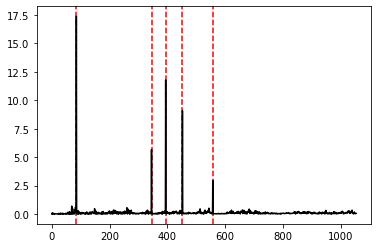

In [20]:
for tid in error_prob_ids:
    plt.axvline(x=tid, color="red", linestyle="--")
plt.plot(sampling_probabilities, color="black")
plt.show()

In [11]:
print(len(sampling_probabilities), len(sampled_traces))

1054 107


In [21]:
outfile = "../../ae_data/dsb-compose-probabilities.csv"
with open(outfile, 'w') as outf:
    outf.write("Probability\n")
    for p in sampling_probabilities:
        outf.write(str(p) + "\n")

In [21]:
print(len(sampling_probabilities))

1124
